## Part1: Feature Extraction

In [7]:
from image_feature_extractor.feature_extraction import extract_features 
from image_feature_extractor.feature_visualization import feature_vis
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
data_path = 'data/'
final_img_features, final_img_filepaths, total_features = extract_features(data_path, 'dinov2_giant') #['dinov2_small','dinov2_big','dinov2_large', 'dinov2_giant']
final_img_features.shape, len(final_img_filepaths), total_features.shape

total number of images:  4
total number of batched:  1


Using cache found in /Users/guro/.cache/torch/hub/facebookresearch_dinov2_main
100%|██████████| 1/1 [00:55<00:00, 55.39s/it]


((4, 1536), 4, torch.Size([4, 1369, 1536]))

In [9]:
total_features.shape    

torch.Size([4, 1369, 1536])

In [10]:
pca_feat = feature_vis(total_features, data_path) #visualize first four image
pca_feat.shape

['lion.jpeg', 'cart3.jpeg', 'cat.jpg', 'rtx1tglo.jpg']


## Part2: Classification

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Subset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy
import random
import torch.optim as optim
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import time
import os
import copy
import random
from PIL import Image
from utils import *

def set_seed(no):
    torch.manual_seed(no)
    random.seed(no)
    np.random.seed(no)
    os.environ['PYTHONHASHSEED'] = str()
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

set_seed(100)

/Users/guro/Desktop/My Workspace/1 - Projects/Image-feature-extraction/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
batch_size = 32

# trainset = torchvision.datasets.Food101(root='./data', split='train',
#                                         download=True, transform=data_transforms['train'])

# testset = torchvision.datasets.Food101(root='./data', split='test',
#                                        download=True, transform=data_transforms['test'])


trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=data_transforms['train'])

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=data_transforms['test'])

print(len(trainset), len(testset))

100%|██████████| 170498071/170498071 [00:08<00:00, 20612428.22it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
50000 10000


In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

train_indices = random.sample(range(len(trainset)), 500)
test_indices = random.sample(range(len(testset)), 100)

train_subset = Subset(trainset, train_indices)
test_subset  = Subset(testset, test_indices)


trainloader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)


testloader = torch.utils.data.DataLoader(test_subset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = trainset.classes

In [7]:
dataloaders = {}
dataloaders['train'] = trainloader
dataloaders['test'] = testloader
dataloaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x142d3a460>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x142e72400>}

In [8]:
dinov2_vits14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')

Using cache found in /Users/guro/.cache/torch/hub/facebookresearch_dinov2_main
xFormers not available
xFormers not available


In [9]:
class DinoVisionTransformerClassifier(nn.Module):
    def __init__(self):
        super(DinoVisionTransformerClassifier, self).__init__()
        self.transformer = dinov2_vits14
        self.classifier = nn.Sequential(
            nn.Linear(dinov2_vits14.num_features, 256),
            nn.ReLU(),
            nn.Linear(256, len(classes))
        )
    
    def forward(self, x):
        x = self.transformer(x)
        x = self.transformer.norm(x)
        x = self.classifier(x)
        return x
model = DinoVisionTransformerClassifier()
model = model.to(device)

In [10]:
model1 = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model1.fc.in_features
model1.fc = nn.Linear(num_ftrs, len(classes))
model1 = model1.to(device)

In [11]:
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.000001)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


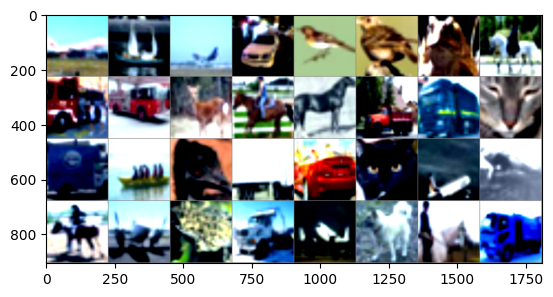

airplane ship  airplane automobile bird  bird  frog  horse truck truck deer  horse horse truck truck cat   truck ship  bird  truck automobile cat   airplane airplane horse airplane frog  truck airplane dog   horse truck


In [12]:
# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [13]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
results = train(model=model,
                       train_dataloader=trainloader,
                       test_dataloader=testloader,
                       optimizer=optimizer,
                       loss_fn=criterion,
                       epochs=10,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

 10%|█         | 1/10 [01:36<14:25, 96.12s/it]

Epoch: 1 | train_loss: 2.4202 | train_acc: 0.1645 | test_loss: 2.1737 | test_acc: 0.1719


 20%|██        | 2/10 [03:09<12:34, 94.30s/it]

Epoch: 2 | train_loss: 2.0453 | train_acc: 0.3063 | test_loss: 1.9205 | test_acc: 0.4062


 30%|███       | 3/10 [04:44<11:02, 94.59s/it]

Epoch: 3 | train_loss: 1.7571 | train_acc: 0.4836 | test_loss: 1.7064 | test_acc: 0.4844


 40%|████      | 4/10 [06:08<09:04, 90.68s/it]

Epoch: 4 | train_loss: 1.5028 | train_acc: 0.6465 | test_loss: 1.4950 | test_acc: 0.5234


 50%|█████     | 5/10 [07:31<07:19, 87.82s/it]

Epoch: 5 | train_loss: 1.2718 | train_acc: 0.7531 | test_loss: 1.3287 | test_acc: 0.6094


 60%|██████    | 6/10 [08:56<05:47, 86.98s/it]

Epoch: 6 | train_loss: 1.0714 | train_acc: 0.8277 | test_loss: 1.1783 | test_acc: 0.6797


 70%|███████   | 7/10 [10:19<04:17, 85.71s/it]

Epoch: 7 | train_loss: 0.8921 | train_acc: 0.8863 | test_loss: 1.0468 | test_acc: 0.7344


 80%|████████  | 8/10 [11:42<02:49, 84.84s/it]

Epoch: 8 | train_loss: 0.7498 | train_acc: 0.9164 | test_loss: 0.9234 | test_acc: 0.7578


 90%|█████████ | 9/10 [13:06<01:24, 84.36s/it]

Epoch: 9 | train_loss: 0.6362 | train_acc: 0.9547 | test_loss: 0.8375 | test_acc: 0.7969


100%|██████████| 10/10 [14:29<00:00, 86.99s/it]

Epoch: 10 | train_loss: 0.5312 | train_acc: 0.9676 | test_loss: 0.7540 | test_acc: 0.8828
[INFO] Total training time: 869.923 seconds


In [ ]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
results = train(model=model1,
                       train_dataloader=trainloader,
                       test_dataloader=testloader,
                       optimizer=optimizer,
                       loss_fn=criterion,
                       epochs=10,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

## Part3: Clustering

In [15]:
from urllib.request import urlopen
from PIL import Image
import timm

img = Image.open(urlopen(
    'https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/beignets-task-guide.png'
))

model = timm.create_model(
    'vit_large_patch14_dinov2.lvd142m',
    pretrained=True,
    num_classes=0,  # remove classifier nn.Linear
)
model = model.eval()

# get model specific transforms (normalization, resize)
data_config = timm.data.resolve_model_data_config(model)
transforms = timm.data.create_transform(**data_config, is_training=False)

output = model(transforms(img).unsqueeze(0))  # output is (batch_size, num_features) shaped tensor

# or equivalently (without needing to set num_classes=0)

output = model.forward_features(transforms(img).unsqueeze(0))
# output is unpooled, a (1, 1370, 1024) shaped tensor

output = model.forward_head(output, pre_logits=True)
# output is a (1, num_features) shaped tensor
output.shape

torch.Size([1, 1024])

## Testing

In [5]:
import torch
import os

In [6]:
dinov2_vitl14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14')

Using cache found in /Users/guro/.cache/torch/hub/facebookresearch_dinov2_main


In [7]:
import requests
from PIL import Image
from torchvision import transforms
# transform = transforms.Compose([           
#                                 transforms.Resize(256),                    
#                                 transforms.CenterCrop(224),               
#                                 transforms.ToTensor(),                    
#                                 transforms.Normalize(                      
#                                 mean=[0.485, 0.456, 0.406],                
#                                 std=[0.229, 0.224, 0.225]              
#                                 )])


transform1 = transforms.Compose([           
                                transforms.Resize(520),
                                transforms.CenterCrop(518), #should be multiple of model patch_size                 
                                transforms.ToTensor(),                    
                                transforms.Normalize(mean=0.5, std=0.2)
                                ])

In [8]:
patch_size = dinov2_vitl14.patch_size # patchsize=14

#520//14
patch_h  = 520//patch_size
patch_w  = 520//patch_size

# feat_dim = 384 # vits14
# feat_dim = 768 # vitb14
feat_dim = 1024 # vitl14
# feat_dim = 1536 # vitg14

folder_path = "data/"
total_features  = []
with torch.no_grad():
  for img_path in os.listdir(folder_path):
    img_path = os.path.join(folder_path, img_path)
    img = Image.open(img_path).convert('RGB')
    img_t = transform1(img)
    
    features_dict = dinov2_vitl14.forward_features(img_t.unsqueeze(0))
    features = features_dict['x_norm_patchtokens']
    total_features.append(features)
total_features = torch.cat(total_features, dim=0)
total_features.shape

torch.Size([4, 1369, 1024])

In [9]:
total_features.shape

torch.Size([4, 1369, 1024])

In [10]:
patch_h = 518//patch_size
patch_w = 518//patch_size
feat_dim = total_features.shape[-1]
img_num = total_features.shape[0]
img_num, feat_dim, patch_w, patch_h

(4, 1024, 37, 37)

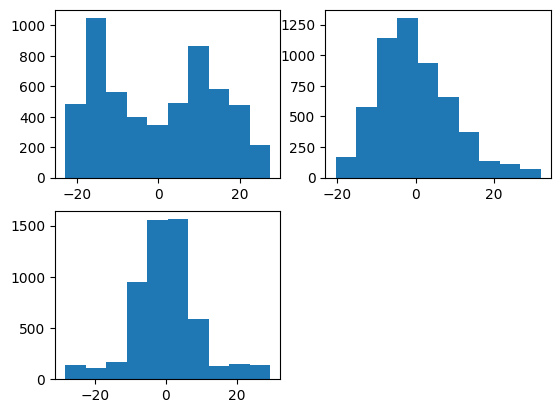

In [11]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# First PCA to Seperate Background
# sklearn expects 2d array for traning

total_features = total_features.reshape(img_num * patch_h * patch_w, feat_dim) #4(*H*w, 1024)

pca = PCA(n_components=3)
pca.fit(total_features)
pca_features = pca.transform(total_features)

# visualize PCA components for finding a proper threshold
# 3 histograms for 3 components
plt.subplot(2, 2, 1)
plt.hist(pca_features[:, 0])
plt.subplot(2, 2, 2)
plt.hist(pca_features[:, 1])
plt.subplot(2, 2, 3)
plt.hist(pca_features[:, 2])
plt.show()
plt.close()

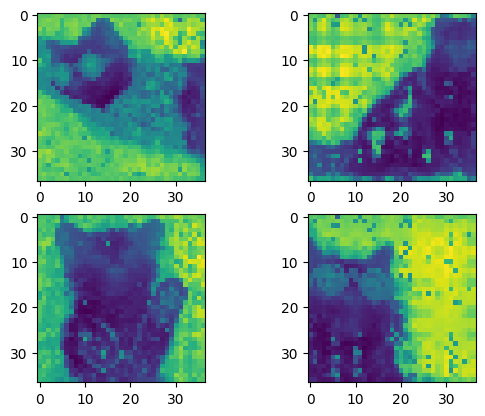

In [15]:
# min_max scale
pca_features[:, 0] = (pca_features[:, 0] - pca_features[:, 0].min()) / \
                     (pca_features[:, 0].max() - pca_features[:, 0].min())
#pca_features = sklearn.processing.minmax_scale(pca_features)

for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(pca_features[i*patch_h*patch_w : (i+1)*patch_h*patch_w, 0].reshape(patch_h, patch_w))

plt.show()

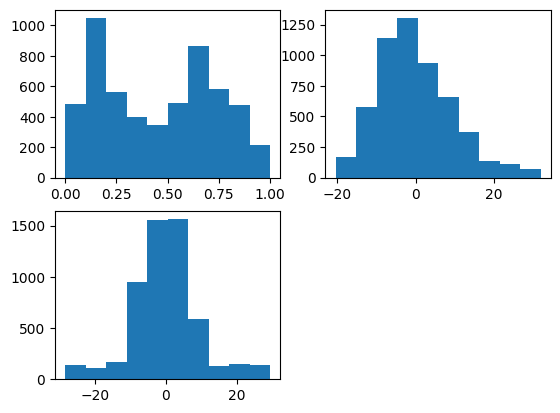

In [16]:
plt.subplot(2, 2, 1)
plt.hist(pca_features[:, 0])
plt.subplot(2, 2, 2)
plt.hist(pca_features[:, 1])
plt.subplot(2, 2, 3)
plt.hist(pca_features[:, 2])
plt.show()
plt.close()

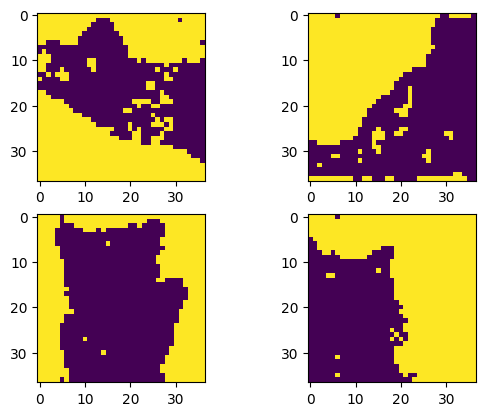

In [17]:
# segment/seperate the backgound and foreground using the first component
pca_features_bg = pca_features[:, 0] > 0.45 # from first histogram
pca_features_fg = ~pca_features_bg

# plot the pca_features_bg
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(pca_features_bg[i * patch_h * patch_w: (i+1) * patch_h * patch_w].reshape(patch_h, patch_w))
plt.show()


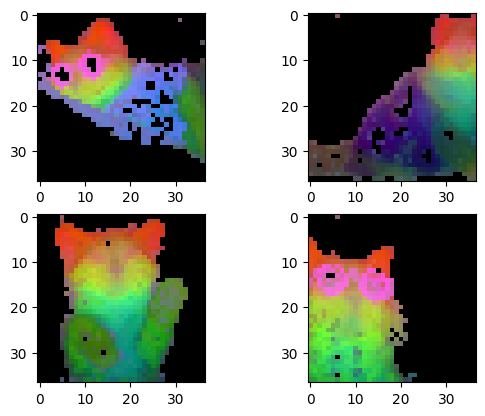

In [20]:
# 2nd PCA for only foreground patches
pca.fit(total_features[pca_features_fg]) 
pca_features_left = pca.transform(total_features[pca_features_fg])

for i in range(3):
    # min_max scaling
    pca_features_left[:, i] = (pca_features_left[:, i] - pca_features_left[:, i].min()) / (pca_features_left[:, i].max() - pca_features_left[:, i].min())

pca_features_rgb = pca_features.copy()
# for black background
pca_features_rgb[pca_features_bg] = 0
# new scaled foreground features
pca_features_rgb[pca_features_fg] = pca_features_left

# reshaping to numpy image format
pca_features_rgb = pca_features_rgb.reshape(4, patch_h, patch_w, 3)
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(pca_features_rgb[i])

plt.show()

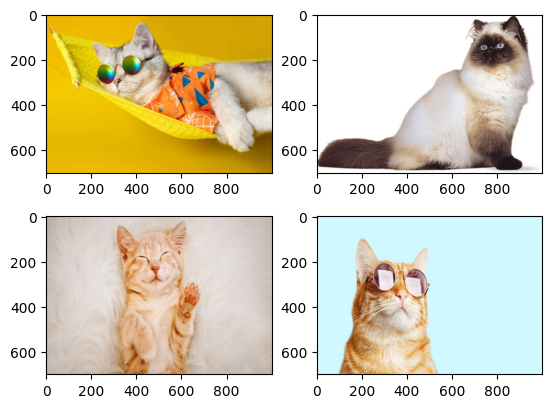

In [21]:
for i,img_path in enumerate(os.listdir(folder_path)):
  img_path = os.path.join(folder_path, img_path)
  img = Image.open(img_path).convert('RGB').resize((1000, 700))
  plt.subplot(2, 2, i+1)
  plt.imshow(img)
plt.show()
     